<a href="https://colab.research.google.com/github/ziatdinovmax/CSSAS-DML/blob/master/2_cssas_prepare_augmented_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare and save augmented data

Prepared by Maxim Ziatdinov (October 2019)


---


This notebook performs the data augmentation procedure for a single image-label pair by applying various transformations (e.g. adding noise and blurring) to a stack of randomly cropped parts of the original image / ground truth.


---

In [0]:
#@title Import modules
# Data manipulation and plotting
import os
import copy
import random
from collections import OrderedDict
import numpy as np
from scipy import ndimage
import cv2
from sklearn.utils import shuffle
from skimage import exposure
from skimage.util import random_noise
import matplotlib
import matplotlib.pyplot as plt

In [0]:
#@title Helper function { form-width: "20%" }
import numpy as np
from scipy import ndimage
import cv2
from sklearn.utils import shuffle
from skimage import exposure
from skimage.util import random_noise
import random


class cropper:
    """
    Augments an input image-mask pair by performing image cropping procedure
    """
    def __init__(self, image, mask, window_size, step_size, batch_size):
        """
        Args:
            image (2d ndarray): image to be cropped (height x width),
            mask (3d ndarray): mask/ground truth (height x width x channels),
            window_size (tuple): width and height of sliding window,
            step_size (float): step size of sliding window,
            batch_size (int): number of images to return.
        """
        if np.ndim(image) == 2:
            image = np.expand_dims(image, axis=2)
        self.image = image
        if np.ndim(mask) == 2:
            mask = np.expand_dims(mask, axis=2)
        self.mask = mask
        self.window_size = window_size
        self.step_size = step_size
        self.batch_size = batch_size

    def sliding_window(self):
        """
        Returns the portion of the input image lying within sliding window
        """
        for y in range(0, self.image.shape[0], self.step_size):
            for x in range(0, self.image.shape[1], self.step_size):
                yield (self.image[y:y + self.window_size[1], x:x + self.window_size[0], :],
                       self.mask[y:y + self.window_size[1], x:x + self.window_size[0], :])

    def imgen(self):
        """
        Returns a batch of cropped images and
        a batch of corresponding labels (ground truth)
        """
        X_batch = np.empty((0, self.window_size[0], self.window_size[1]))
        y_batch = np.empty((0, self.window_size[0], self.window_size[1]))
        for window in self.sliding_window():
            if window[0].shape[: -1] != self.window_size:
                continue
            window_i = np.transpose(window[0], [2, 0, 1])
            window_l = np.transpose(window[1], [2, 0, 1])
            X_batch = np.append(X_batch, window_i, axis=0)
            y_batch = np.append(y_batch, window_l, axis=0)
        X_batch, y_batch = shuffle(X_batch, y_batch)
        X_batch = X_batch[0:self.batch_size]
        y_batch = y_batch[0:self.batch_size]
        return X_batch, y_batch


class data_transform:
    """
    Applies a sequence of pre-defined operations for data augmentation.
    """
    def __init__(self, batch_size, width, height,
                 channels, dim_order='pytorch',
                 norm=1, **kwargs):
        """
        Args:
            batch_size (int): number of images in the batch,
            width (int): width of images in the batch,
            height (int): height of images in the batch,
            channels (int): number of classes (channels) in the ground truth
            dim_order (str): channel first (pytorch) or channel last (otherwise) ordering
            norm (int): normalization to 1,
            **flip (bool): image vertical/horizonal flipping,
            **rotate90 (bool): rotating image by +- 90 deg,
            **zoom (tuple): values for zooming-in (min height, max height, step);
              assumes height==width,
            **noise (dict): dictionary of noise values for each type of noise,
            **resize (tuple): values for image resizing (min height, max height, step);
              assumes heght==width.
        """
        self.n, self.w, self.h = batch_size, width, height
        self.ch = channels
        self.dim_order = dim_order
        self.norm = norm
        self.flip = kwargs.get('flip')
        self.rotate90 = kwargs.get('rotate90')
        self.zoom = kwargs.get('zoom')
        self.noise = kwargs.get('noise')
        self.resize = kwargs.get('resize')

    def transform(self, images, masks):
        """
        Applies a sequence of augmentation procedures
        to images and (except for noise) ground truth
        """
        images = (images - np.amin(images))/np.ptp(images)
        if self.flip:
            images, masks = self.batch_flip(images, masks)
        if self.noise is not None:
            images, masks = self.batch_noise(images, masks)
        if self.zoom is not None:
            images, masks = self.batch_zoom(images, masks)
        if self.resize is not None:
            images, masks = self.batch_resize(images, masks)
        if self.dim_order == 'pytorch':
            images = np.expand_dims(images, axis=1)
            masks = np.transpose(masks, (0, 3, 1, 2))
        else:
            images = np.expand_dims(images, axis=3)
            images = images.astype('float32')
        if self.norm != 0:
            images = (images - np.amin(images))/np.ptp(images)
        return images, masks

    def batch_noise(self, X_batch, y_batch,):
        """
        Takes an image stack and applies
        various types of noise to each image
        """
        def make_pnoise(image, l):
            vals = len(np.unique(image))
            vals = (l/50) ** np.ceil(np.log2(vals))
            image_n_filt = np.random.poisson(image * vals) / float(vals)
            return image_n_filt
        pnoise_range = self.noise['poisson']
        spnoise_range = self.noise['salt and pepper']
        gnoise_range = self.noise['gauss']
        blevel_range = self.noise['blur']
        c_level_range = self.noise['contrast']
        X_batch_a = np.zeros((self.n, self.w, self.h))
        for i, img in enumerate(X_batch):
            pnoise = random.randint(pnoise_range[0], pnoise_range[1])
            spnoise = random.randint(spnoise_range[0], spnoise_range[1])
            gnoise = random.randint(gnoise_range[0], gnoise_range[1])
            blevel = random.randint(blevel_range[0], blevel_range[1])
            clevel = random.randint(c_level_range[0], c_level_range[1])
            img = ndimage.filters.gaussian_filter(img, blevel*1e-1)
            img = make_pnoise(img, pnoise)
            img = random_noise(img, mode='gaussian', var=gnoise*1e-4)
            img = random_noise(img, mode='pepper', amount=spnoise*1e-3)
            img = random_noise(img, mode='salt', amount=spnoise*5e-4)
            img = exposure.adjust_gamma(img, clevel*1e-1)
            X_batch_a[i, :, :] = img
        return X_batch_a, y_batch

    def batch_zoom(self, X_batch, y_batch):
        """
        Crops and then resizes to the original size
        all images in one batch
        """
        zoom_list = np.arange(self.zoom[0], self.zoom[1], self.zoom[2])
        X_batch_a = np.zeros((self.n, self.w, self.h))
        y_batch_a = np.zeros((self.n, self.w, self.h, self.ch))
        for i, (img, gt) in enumerate(zip(X_batch, y_batch)):
            rs = np.random.choice(zoom_list)
            w1 = int((self.w-rs)/2)
            w2 = int(rs + (self.w-rs)/2)
            h1 = int((self.h-rs)/2)
            h2 = int(rs + (self.h-rs)/2)
            img = img[w1:w2, h1:h2]
            gt = gt[w1:w2, h1:h2]
            img = cv2.resize(img, (self.w, self.h))
            gt = cv2.resize(gt, (self.w, self.h))
            _, gt = cv2.threshold(gt, 0.25, 1, cv2.THRESH_BINARY)
            if len(gt.shape) != 3:
                gt = np.expand_dims(gt, axis=2)
            X_batch_a[i, :, :] = img
            y_batch_a[i, :, :, :] = gt
        return X_batch_a, y_batch_a

    def batch_flip(self, X_batch, y_batch):
        """
        Flips and rotates all images and in one batch
        and correponding labels (ground truth)
        """
        X_batch_a = np.zeros((self.n, self.w, self.h))
        y_batch_a = np.zeros((self.n, self.w, self.h, self.ch))
        int_r = (-1, 3) if self.rotate90 else (-1, 1)
        for i, (img, gt) in enumerate(zip(X_batch, y_batch)):
            flip_type = random.randint(int_r[0], int_r[1])
            if flip_type == 3:
                img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                gt = cv2.rotate(gt, cv2.ROTATE_90_CLOCKWISE)
            elif flip_type == 2:
                img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                gt = cv2.rotate(gt, cv2.ROTATE_90_COUNTERCLOCKWISE)
            else:
                img = cv2.flip(img, flip_type)
                gt = cv2.flip(gt, flip_type)
            if len(gt.shape) != 3:
                gt = np.expand_dims(gt, axis=2)
            X_batch_a[i, :, :] = img
            y_batch_a[i, :, :, :] = gt
        return X_batch_a, y_batch_a

    def batch_resize(self, X_batch, y_batch):
        """
        Resize all images in one batch and
        corresponding labels (ground truth)
        """
        rs_arr = np.arange(self.resize[0], self.resize[1], self.resize[2])
        rs = np.random.choice(rs_arr)
        if X_batch.shape[1:3] == (rs, rs):
            return X_batch, y_batch
        X_batch_a = np.zeros((self.n, rs, rs))
        y_batch_a = np.zeros((self.n, rs, rs, self.ch))
        for i, (img, gt) in enumerate(zip(X_batch, y_batch)):
            img = cv2.resize(img, (rs, rs), cv2.INTER_CUBIC)
            gt = cv2.resize(gt, (rs, rs), cv2.INTER_CUBIC)
            _, gt = cv2.threshold(gt, 0.25, 1, cv2.THRESH_BINARY)
            if len(gt.shape) < 3:
                gt = np.expand_dims(gt, axis=-1)
            X_batch_a[i, :, :] = img
            y_batch_a[i, :, :, :] = gt
        return X_batch_a, y_batch_a

Load data:

( you can download it from google drive using `gdown` command or mount a google drive and load it from there or upload using the left pane (Files --> Upload) )

In [0]:
!gdown https://drive.google.com/uc?id=1YW6supxK8iDwDBcJlDXGHvmPxXqA1BJP
!gdown https://drive.google.com/uc?id=1k8jnE_1lp131Go59VVTFwnkjNP1irkMC

Downloading...
From: https://drive.google.com/uc?id=1YW6supxK8iDwDBcJlDXGHvmPxXqA1BJP
To: /content/KCl_100mM-part2-image.npy
100% 262k/262k [00:00<00:00, 77.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k8jnE_1lp131Go59VVTFwnkjNP1irkMC
To: /content/KCl_100mM-part2-masknew.npy
2.10MB [00:00, 62.4MB/s]


In [0]:
imgsrc = np.load('/content/KCl_100mM-part2-image.npy')
mask = np.load('/content/KCl_100mM-part2-masknew.npy')

Plot uplaoded data (image-label pair):

Text(0.5, 1.0, 'ground truth')

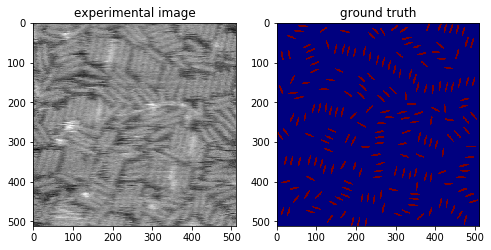

In [0]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
ax1.imshow(imgsrc, cmap='gray')
ax1.set_title('experimental image')
ax2.imshow(imgsrc, cmap='gray')
ax2.imshow(mask[:, :, 0], cmap='jet', alpha=1.)
ax2.set_title('ground truth')

## Data augmentation

We next define parameters for data augmentation procedure, including size of each produced image, noise parameters (as a dictionary) and zoom-in range.

In [0]:
### Define parameters of image croppping ###
window_size = (256, 256) # sliding window size
step_size = 18 # sliding window step
batch_size = 32 # notice that large batch size may not fit into GPU memory
n_channels = 1 #equal to the number of classes
### Define image distortion/noise parameters ###
zoom = (224, 256+1, 8)
resize = (256-32, 256+32+1, 8)
noise_dict = {} # Noise parameters are defined as dictionary
noise_dict['poisson'] = (80, 110) # smaller values result to larger P noise
noise_dict['gauss'] = (0, 800)# smaller values result in smaller G noise
noise_dict['blur'] = (0, 3)
noise_dict['contrast'] = (6, 35)
noise_dict['salt and pepper'] = (0,5)

We can now perform a data augmentation procedure. First, we produce a stack of cropped images by sliding a window of the selected size across the original image and extracting the image portion that ovelpaps with the window at each 'sliding step'. Then we apply various transformations/distortions (such as gaussian noise and scan scars) to each image in the stack.

In [0]:
# Generate a batch of cropped image-mask pairs
imcrop = cropper(imgsrc, mask, window_size, step_size, batch_size)
images, labels = imcrop.imgen()
# Apply specific transformations to each image in the batch
imaug = data_transform(
    batch_size, window_size[0], window_size[1], n_channels,
    noise=noise_dict, zoom=zoom, flip=True, scars=False,
    resize=resize
)
images, labels = imaug.transform(images, labels)

Plot some of the augmented images with the corresponding ground truth (aka labels):

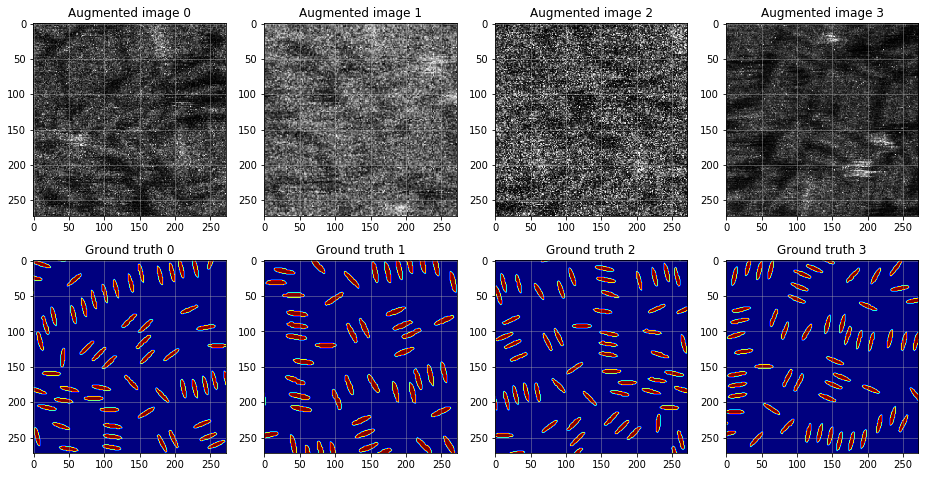

In [0]:
n = 4

n = n + 1
fig = plt.figure( figsize=(20, 8))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1,0,:,:], cmap = 'gray')
    ax.set_title('Augmented image ' + str(i-1) )
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(labels[i-1,0,:,:], cmap = 'jet', Interpolation = 'Gaussian')
    ax.set_title('Ground truth ' + str(i-1))
    ax.grid(alpha = 0.5)

If we like it, let's generate more augmented images and store them:

In [0]:
n_batches = 50
X_train = {}
y_train = {}
for i in range(n_batches):
    print('\r{}/{}'.format(i+1, n_batches), end="")
    images, labels = imcrop.imgen()
    images, labels = imaug.transform(images, labels)
    X_train[i] = copy.deepcopy(images)
    y_train[i] = copy.deepcopy(labels)

50/50

View some of the produced data:

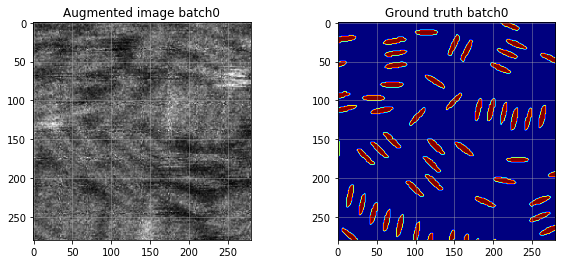

In [0]:
i = 1 # batch number
j = 0 # number of image in a batch
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(X_train[i][j,0,:,:], cmap='gray')
ax1.set_title('Augmented image batch' + str(i-1) )
ax1.grid(alpha=0.5)
ax2.imshow(y_train[i][j,0,:,:], cmap='jet', Interpolation='Gaussian')
ax2.set_title('Ground truth batch' + str(i-1))
ax2.grid(alpha=0.5)

Save the augmented data to google drive:

*(modify the savedir depending on where you want to save them)*

In [0]:
savedir = 'drive/Shared drives/CSSAS-ML/training_data'

from google.colab import drive
drive.mount('/content/drive')
np.save(os.path.join(savedir, 'pnnl_training_images.npy'), X_train)
np.save(os.path.join(savedir, 'pnnl_training_labels.npy'), y_train)